In [1]:
%reload_ext autoreload
%autoreload 2
import os
import numpy as np
import random
import warnings
import torch
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from Probe import probe_shapelet,ShapeletProber
import utils
from utils import *

import sklearn
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

In [4]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [5]:
selected_training = [
    "ACSF1",
    "StandWalkJump",
    "NonInvasiveFetalECGThorax2",
    "Adiac",
    "ArrowHead",
    "BeetleFly",
    "Phoneme",
    "UWaveGestureLibraryZ",
    "UWaveGestureLibraryY",
    "Lightning2",
    "Coffee",
    "TwoLeadECG",
    "WormsTwoClass",
    "CricketY",
    "Meat",
    "BirdChicken",
    "FaceFour",
    "ECGFiveDays",
    "Worms",
    "StarLightCurves",
]

In [6]:
torch.manual_seed(42)

In [7]:
all_datasets = selected_training + selected_uni

In [8]:
# diverse_training = random.sample(all_datasets, 20)
# diverse_probing = list(set(all_datasets) - set(diverse_training))
diverse_training = selected_training
diverse_probing = selected_uni

In [9]:
print('diverse_training:',diverse_training)
print('diverse_probing:',diverse_probing)

diverse_training: ['ACSF1', 'StandWalkJump', 'NonInvasiveFetalECGThorax2', 'Adiac', 'ArrowHead', 'BeetleFly', 'Phoneme', 'UWaveGestureLibraryZ', 'UWaveGestureLibraryY', 'Lightning2', 'Coffee', 'TwoLeadECG', 'WormsTwoClass', 'CricketY', 'Meat', 'BirdChicken', 'FaceFour', 'ECGFiveDays', 'Worms', 'StarLightCurves']
diverse_probing: ['ECG200', 'Beef', 'ElectricDevices', 'Earthquakes', 'Wafer', 'PowerCons', 'NonInvasiveFetalECGThorax1', 'ECG5000', 'GunPoint', 'HandOutlines', 'CBF', 'FordA', 'TwoPatterns', 'UWaveGestureLibraryAll', 'Chinatown', 'Yoga', 'DistalPhalanxOutlineCorrect', 'Computers', 'ShapesAll', 'Strawberry']


In [ ]:
s7 = np.sin(np.linspace(0,2*np.pi,21)) + np.sin(np.linspace(0,4*np.pi,21))
shapelet = s7
instance_length = 150
pdata_dict = get_pdata(shapelet=shapelet, selected_datasets=diverse_training, inst_length=instance_length, 
                   num_shapelet=1, is_add=False, repeat_max=100,
                   is_z_norm=True, 
                   is_blending=False, blend_length=5,
                   is_best_insert=True,
                   save_dir='models/simu9/data.pkl')
print(pdata_dict['pdata_ws'].shape)
data_train = np.concatenate((pdata_dict['pdata_ws'],pdata_dict['pdata_wos']),axis=0)
data_label = np.array([0]*len(pdata_dict['pdata_ws'])+[1]*len(pdata_dict['pdata_wos']))

In [12]:
train_x, test_x, train_y, test_y = train_test_split(
    data_train, data_label, test_size=0.2, random_state=42)

enc1 = sklearn.preprocessing.OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
train_y = enc1.transform(train_y.reshape(-1, 1))
test_y = enc1.transform(test_y.reshape(-1, 1))
data = {
    'train_x': train_x,
    'test_x': test_x,
    'train_y': train_y,
    'test_y': test_y
}

model_dataset_path = 'models/simu9'

if not os.path.exists(model_dataset_path):
    os.makedirs(model_dataset_path)

with open(model_dataset_path+'/data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [13]:
model = FCN(c_in=1,c_out=2)

# model = InceptionTime(c_in=1,c_out=2)

train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128, batch_size_test=32)
fit(model, train_loader, device=device, num_epochs=200)
torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')
test_preds, ground_truth = get_all_preds(model, test_loader, device=device)
ground_truth = np.argmax(ground_truth, axis=1)
np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
acc = accuracy_score(ground_truth, test_preds)
print(f'acc:{acc:.3f}')
a = classification_report(ground_truth, test_preds, output_dict=True)
dataframe = pd.DataFrame.from_dict(a)
dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [00:11<00:00, 17.18it/s]


acc:0.996


In [14]:
un_trained_model = FCN(c_in=1,c_out=2)
un_trained_model.eval()

FCN(
  (convblock1): ConvBlock(
    (0): Conv1d(1, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock2): ConvBlock(
    (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convblock3): ConvBlock(
    (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (gap): GAP1d(
    (gap): AdaptiveAvgPool1d(output_size=1)
    (flatten): Reshape(bs)
  )
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [15]:
from tsai.models.FCN import FCN

model_path = 'models/simu9/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()
with open(model_path+'/data.pkl', 'rb') as f:
    data = pickle.load(f)
data.keys()
train_x, test_x, train_y, test_y = data['train_x'], data['test_x'], data['train_y'], data['test_y']
test_preds = np.load(model_path+'/test_preds.npy')
test_y = np.argmax(test_y, axis=1)
train_y = np.argmax(train_y, axis=1)

535

DeepLift


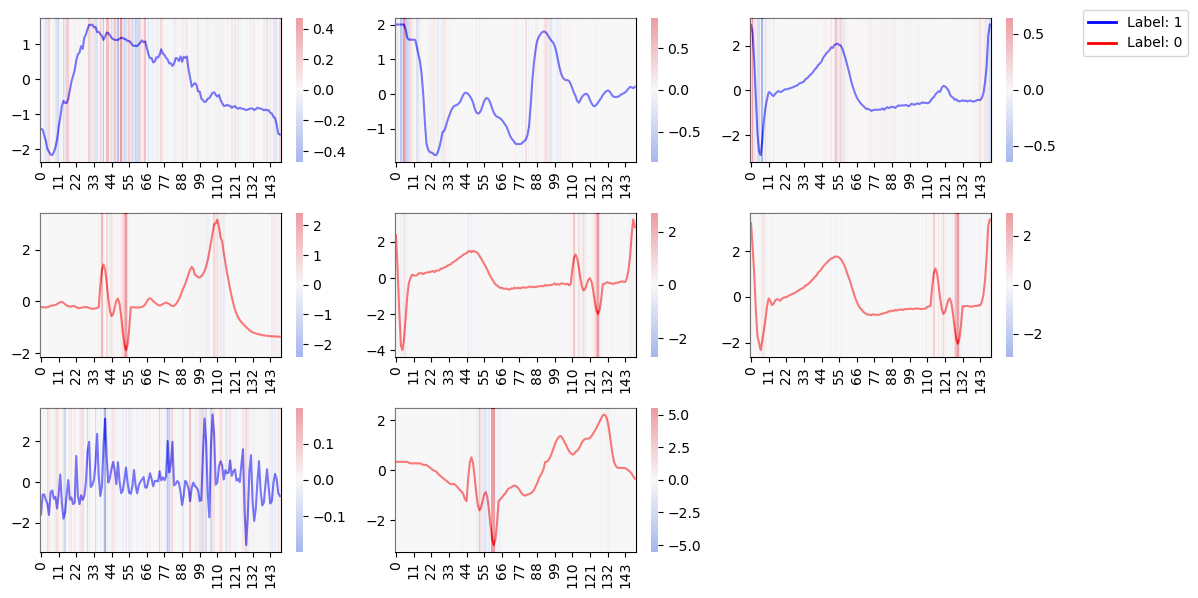

In [197]:
for xai_name in ['DeepLift']:
    print(xai_name)
    attr_gp, _= get_attr(model,test_x,None,None,
                            save_dir=f'attributions/simu9/{xai_name}/exp.pkl',
                            xai_name=xai_name,target_class=0)
    # with open(f'attributions/simu9/{xai_name}/exp.pkl', 'rb') as f:
    #     attr = pickle.load(f)
    # attr_gp = attr['attributions']
    plot_indices = np.arange(8)
    plot_multiple_images_with_attribution(test_x[plot_indices], test_y[plot_indices], 8, figsize=(12,6), 
                                  use_attribution=True,
                                  attributions=attr_gp[plot_indices],
                                  normalize_attribution=True,
                                  save_path=None,
                                  test_y = test_preds[plot_indices],
                                  # startings=[[30]]*8,
                                  # shapelet_length=15
                                 )
    

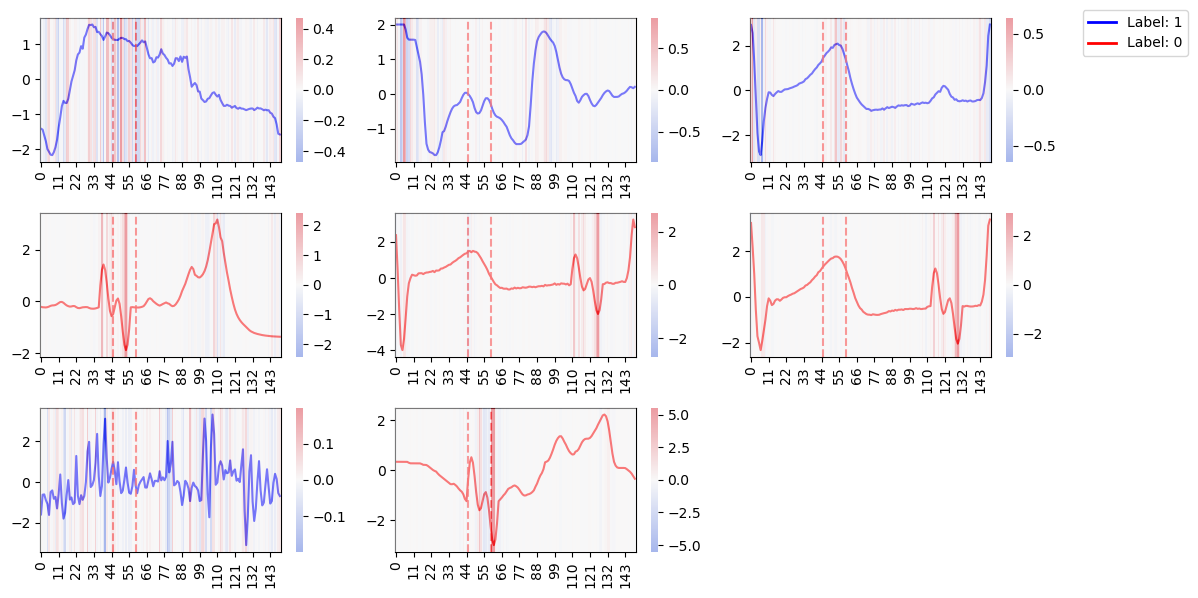

In [32]:
plot_indices = np.arange(8)
plot_multiple_images_with_attribution(test_x[plot_indices], test_y[plot_indices], 8, figsize=(12,6), 
                              use_attribution=True,
                              attributions=attr_gp[plot_indices],
                              normalize_attribution=True,
                              save_path=None,
                              test_y = test_preds[plot_indices],
                              startings=[[45]]*8,
                              shapelet_length=15
                                      
                                 )

In [19]:
s7 = np.sin(np.linspace(0,2*np.pi,21)) + np.sin(np.linspace(0,4*np.pi,21))
s8 = np.cos(np.linspace(0,2*np.pi,21)) + np.cos(np.linspace(0,4*np.pi,21))
# s9 = create_1d_zigzag_array(21, 7)*4-2

In [20]:
diverse_training

['ACSF1',
 'StandWalkJump',
 'NonInvasiveFetalECGThorax2',
 'Adiac',
 'ArrowHead',
 'BeetleFly',
 'Phoneme',
 'UWaveGestureLibraryZ',
 'UWaveGestureLibraryY',
 'Lightning2',
 'Coffee',
 'TwoLeadECG',
 'WormsTwoClass',
 'CricketY',
 'Meat',
 'BirdChicken',
 'FaceFour',
 'ECGFiveDays',
 'Worms',
 'StarLightCurves']

In [21]:
diverse_probing

['ECG200',
 'Beef',
 'ElectricDevices',
 'Earthquakes',
 'Wafer',
 'PowerCons',
 'NonInvasiveFetalECGThorax1',
 'ECG5000',
 'GunPoint',
 'HandOutlines',
 'CBF',
 'FordA',
 'TwoPatterns',
 'UWaveGestureLibraryAll',
 'Chinatown',
 'Yoga',
 'DistalPhalanxOutlineCorrect',
 'Computers',
 'ShapesAll',
 'Strawberry']

In [321]:
seen_feature = s7
instance_length = 150
save_dir = 'probe/simu9/feature'
save_dir_pdata = 'probe/simu9/feature/pdata.pkl'
# pdata_dict = get_pdata(shapelet=seen_feature, selected_datasets=diverse_probing, inst_length=instance_length,  #selected_datasets=diverse_probing
#                   num_shapelet=1, is_add=False, repeat_max=100,
#                   is_best_insert = True,
#                   is_z_norm=True, save_dir=save_dir_pdata)


pdata_dict = pickle_load_from_file(save_dir_pdata)
pdata = np.concatenate((pdata_dict['pdata_ws'],pdata_dict['pdata_wos']), axis=0)
print(train_x.shape, pdata.shape)
p_data_labels = np.array([0]*len(pdata_dict['pdata_ws']) +[1]*len(pdata_dict['pdata_wos']))

shapelet_labels = [test_y, p_data_labels]

# pc
prober = ShapeletProber(model, device='cuda', save_path=save_dir, is_verbose=False)
results = prober.probe(dataset=test_x, labels=test_y, pdata=pdata, shapelet=None, pos=None, 
                           shapelet_labels=shapelet_labels, 
                           is_threshold_info_gain=False,
                           classifier_type='LR', save_results=True, use_saved_latent=False, merge_latent=False)

probe_coef = results['classifier'].coef_.flatten()
train_acc = results['train_acc']
test_acc =  results['test_acc']
original_acc = results['accuracy']
fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
scores = fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight) 
print(f'probing training acc: {train_acc:.2f}')
print(f'probing testing acc: {test_acc:.2f}')
print(f'original instance acc: {original_acc:.2f}')
print(scores)

(2147, 1, 150) (3460, 1, 150)
probing training acc: 1.00
probing testing acc: 1.00
original instance acc: 1.00
-0.8682537825917616


In [374]:
save_dir_pdata = 'probe/simu9/feature/probe_latent_label.pkl'
save_dir_results = 'probe/simu9/feature/results.pkl'
platent = pickle_load_from_file(save_dir_pdata)
probe_results = pickle_load_from_file(save_dir_results)
dataset_latent = platent['dataset_latent']
probe_coef = probe_results['classifier'].coef_.flatten()
probe_intercept = probe_results['classifier'].intercept_.flatten()

model_path = 'models/simu9/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.to(device)
model.eval()
fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
scores = fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight) 
print(scores)
latent_CF = flipped_projection(dataset_latent, probe_coef, probe_intercept,epsilon=0.1)
CF_result = model.fc(torch.from_numpy(latent_CF).float().to(device))
CF_pred = np.argmax(CF_result.clone().cpu().detach().numpy(), axis=1)


latent_result = model.fc(torch.from_numpy(dataset_latent).float().to(device))
latent_pred = np.argmax(CF_result.clone().cpu().detach().numpy(), axis=1)

print(np.count_nonzero(CF_pred!=test_preds)/len(latent_pred))


-0.8682537825917616
0.4208566108007449


In [388]:
np.mean(CF_result[(CF_pred==test_preds)&(test_y==0)].clone().cpu().detach().numpy(), axis=0)

array([ 0.95786613, -0.8464267 ], dtype=float32)

In [389]:
np.mean(latent_result[(CF_pred==test_preds)&(test_y==0)].clone().cpu().detach().numpy(), axis=0)

array([ 4.672947, -4.330929], dtype=float32)

In [331]:
fc_weight1 = model.fc.weight[1].clone().cpu().detach().numpy()

fc_weight @ fc_weight1 / np.linalg.norm(fc_weight) / np.linalg.norm(fc_weight1) 

-0.9458498

In [380]:
model.fc.bias[0]

tensor(-0.0763, device='cuda:0', grad_fn=<SelectBackward0>)

In [379]:
model.fc.bias[1].clone().cpu().detach().numpy()

array(-0.00181848, dtype=float32)

In [349]:
y_pred = model.fc(torch.from_numpy(dataset_latent).float().to(device))
y_pred

tensor([[-4.8698,  4.5431],
        [-4.7724,  4.5818],
        [-4.6701,  4.4205],
        ...,
        [ 2.3056, -2.0883],
        [-4.4724,  4.0237],
        [ 6.6735, -5.9364]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [350]:
CF_result

tensor([[-1.5894,  1.4663],
        [-1.6557,  1.6586],
        [-1.5180,  1.4641],
        ...,
        [ 2.0370, -1.8364],
        [-1.0679,  0.8305],
        [ 3.0881, -2.5735]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [43]:
seen_nonfeature = test_x[4,:,30:45].flatten()
instance_length = 150

save_dir = 'probe/simu9/nonfeature'
save_dir_pdata = 'probe/simu9/nonfeature/pdata.pkl'
pdata_dict = get_pdata(shapelet=seen_nonfeature, selected_datasets=diverse_probing, inst_length=instance_length,  #selected_datasets=diverse_probing
                  num_shapelet=1, is_add=False, repeat_max=100,
                  is_best_insert = True,
                  is_z_norm=True, save_dir=save_dir_pdata)


pdata_dict = pickle_load_from_file(save_dir_pdata)
pdata = np.concatenate((pdata_dict['pdata_ws'],pdata_dict['pdata_wos']), axis=0)
print(train_x.shape, pdata.shape)
p_data_labels = np.array([0]*len(pdata_dict['pdata_ws']) +[1]*len(pdata_dict['pdata_wos']))

shapelet_labels = [test_y, p_data_labels]

# pc
prober = ShapeletProber(model, device='cuda', save_path=save_dir, is_verbose=False)
results = prober.probe(dataset=test_x, labels=test_y, pdata=pdata, shapelet=None, pos=None, 
                           shapelet_labels=shapelet_labels, 
                           is_threshold_info_gain=False,
                           classifier_type='LR', save_results=True, use_saved_latent=False, merge_latent=False)

# results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, save_path=save_dir,
#                          shapelet=seen_feature, pos=None, device='cuda:1',shapelet_labels=shapelet_labels)

probe_coef = results['classifier'].coef_.flatten()
train_acc = results['train_acc']
test_acc =  results['test_acc']
original_acc = results['accuracy']
fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
scores = fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight) 
print(f'probing training acc: {train_acc:.2f}')
print(f'probing testing acc: {test_acc:.2f}')
print(f'original instance acc: {original_acc:.2f}')
print(scores)

(2147, 1, 150) (3460, 1, 150)
probing training acc: 0.68
probing testing acc: 0.63
original instance acc: 0.61
-0.03793532732509236


In [69]:
def project_onto_hyperplane(points, w, b):
    w_norm = np.linalg.norm(w)
    projections = points - ((np.dot(points, w) + b) / (w_norm**2))[:, np.newaxis] * w
    return projections
    
def flipped_projection(points, w, b, epsilon=0.1):
    """
    Project points onto the hyperplane and then flip their positions to the opposite side.
    """
    # Regular projection
    w_norm = np.linalg.norm(w)
    projections = points - ((np.dot(points, w) + b) / (w_norm**2))[:, np.newaxis] * w

    # Determine side of the hyperplane for each point
    signed_distance = np.dot(points, w) + b
    flip_direction = -np.sign(signed_distance)  # Flip the side

    # Modify projection to the opposite side
    flipped_projections = projections + flip_direction[:, np.newaxis] * epsilon * (w / w_norm)
    return flipped_projections

In [370]:
model_path = 'models/simu9/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.to(device)
model.eval()

latent_CF = flipped_projection(dataset_latent, probe_coef, probe_intercept,epsilon=0.1)
CF_result = model.fc(torch.from_numpy(latent_CF).float().to(device))
CF_pred = np.argmax(CF_result.clone().cpu().detach().numpy(), axis=1)
np.count_nonzero(CF_pred!=test_preds)/len(test_preds)

0.0

-0.8779514594222648

In [167]:
fc_weight.shape

(128,)

0.4208566108007449

In [352]:
CF_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [124]:
y_pred = model.fc(torch.from_numpy(dataset_latent).float().to(device))
y_pred

tensor([[-4.8698,  4.5431],
        [-4.7724,  4.5818],
        [-4.6701,  4.4205],
        ...,
        [ 2.3056, -2.0883],
        [-4.4724,  4.0237],
        [ 6.6735, -5.9364]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [125]:
CF_result

tensor([[ 0.8932, -0.8642],
        [ 0.8105, -0.6565],
        [ 0.9466, -0.8495],
        ...,
        [-0.4747,  0.5204],
        [ 1.4101, -1.4958],
        [ 0.5158, -0.1588]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
laten_CF @ fc_weight

In [45]:
seen_nonfeature = test_x[4,:,45:60].flatten()
instance_length = 150

save_dir = 'probe/simu9/nonfeature2'
save_dir_pdata = 'probe/simu9/nonfeature2/pdata.pkl'
pdata_dict = get_pdata(shapelet=seen_nonfeature, selected_datasets=diverse_probing, inst_length=instance_length,  #selected_datasets=diverse_probing
                  num_shapelet=1, is_add=False, repeat_max=100,
                  is_best_insert = True,
                  is_z_norm=True, save_dir=save_dir_pdata)


pdata_dict = pickle_load_from_file(save_dir_pdata)
pdata = np.concatenate((pdata_dict['pdata_ws'],pdata_dict['pdata_wos']), axis=0)
print(train_x.shape, pdata.shape)
dataset_s_label = train_y
p_data_labels = np.array([0]*len(pdata_dict['pdata_ws']) +[1]*len(pdata_dict['pdata_wos']))

shapelet_labels = [test_y, p_data_labels]

shapelet_labels = [test_y, p_data_labels]

# pc
prober = ShapeletProber(model, device='cuda', save_path=save_dir, is_verbose=False)
results = prober.probe(dataset=test_x, labels=test_y, pdata=pdata, shapelet=None, pos=None, 
                           shapelet_labels=shapelet_labels, 
                           is_threshold_info_gain=False,
                           classifier_type='LR', save_results=True, use_saved_latent=False, merge_latent=False)


probe_coef = results['classifier'].coef_.flatten()
train_acc = results['train_acc']
test_acc =  results['test_acc']
original_acc = results['accuracy']
fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
scores = fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight) 
print(f'probing training acc: {train_acc:.2f}')
print(f'probing testing acc: {test_acc:.2f}')
print(f'original instance acc: {original_acc:.2f}')
print(scores)

(2147, 1, 150) (3460, 1, 150)
probing training acc: 0.67
probing testing acc: 0.66
original instance acc: 0.65
0.00046459717837063014


In [55]:
seen_feature = s7
instance_length = 150

save_dir = 'probe/simu9/feature_untrained/'
save_dir_pdata = 'probe/simu9/feature_untrained/pdata.pkl'

pdata_dict = get_pdata(shapelet=seen_feature, selected_datasets=diverse_probing, inst_length=instance_length,  #selected_datasets=diverse_probing
                  num_shapelet=1, is_add=False, repeat_max=100,
                  is_best_insert = True,
                  is_z_norm=True, save_dir=save_dir_pdata)

pdata_dict = pickle_load_from_file(save_dir_pdata)
pdata = np.concatenate((pdata_dict['pdata_ws'],pdata_dict['pdata_wos']), axis=0)
print(train_x.shape, pdata.shape)
dataset_s_label = train_y
p_data_labels = np.array([0]*len(pdata_dict['pdata_ws']) +[1]*len(pdata_dict['pdata_wos']))

shapelet_labels = [train_y, p_data_labels]

# pc
results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=un_trained_model, save_path=save_dir,
                         shapelet=seen_feature, pos=None, device='cuda:1',shapelet_labels=shapelet_labels)

probe_coef = results['classifier'].coef_.flatten()
train_acc = results['train_acc']
test_acc =  results['test_acc']
original_acc = results['accuracy']
fc_weight_untrained = un_trained_model.fc.weight[0].clone().cpu().detach().numpy()
scores = fc_weight_untrained @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight) 
print(f'probing training acc: {train_acc:.2f}')
print(f'probing testing acc: {test_acc:.2f}')
print(f'original instance acc: {original_acc:.2f}')
print(scores)

(2147, 1, 150) (3460, 1, 150)
[0 0 0 ... 1 1 1]
(2147, 128) (3460, 128)
probing training acc: 0.88
probing testing acc: 0.86
original instance acc: 0.75
0.024250397888365027


In [133]:
xai_names

['DeepLift',
 'IntegratedGradients',
 'InputXGradient',
 'Saliency',
 'Lime',
 'Occlusion',
 'KernelShap',
 'GuidedBackprop']

In [176]:
implet_cluster_results = pickle_load_from_file('figure/simu9_diverse/attr_None_sample_pred_0/IntegratedGradients/implets_cluster_results.pkl')
# implets
implets = pickle_load_from_file('figure/simu9_diverse/attr_None_sample_pred_0/IntegratedGradients/implets.pkl')['implets']

In [177]:
cluster_indices = implet_cluster_results['best_indices_dep']

cluster: 0 0 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211}


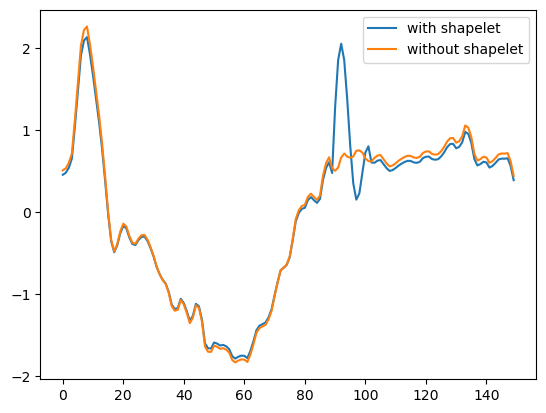

probing training acc: 0.78
probing testing acc: 0.78
original instance acc: 0.82
-0.24254536487312706


In [178]:
probe_coefs = []
for i,(cluster_index, cluster_instance) in enumerate(cluster_indices.items()):
    print(f'cluster: {i}', cluster_index, cluster_instance)
    clsuter_implets = [implets[i][1].flatten() for i in cluster_instance]
    clsuter_implets_instance_number = [implets[i][0] for i in cluster_instance]
    # for impl in clsuter_implets:
    #     plt.plot(impl,color='blue')
    # plt.show()
    save_dir = f'probe/simu9/implet{i}/'
    save_dir_pdata = f'probe/simu9/implet{i}/pdata.pkl'
    selected_datasets = selected_uni

    pdata = get_pdata(shapelet=clsuter_implets, selected_datasets=selected_datasets, inst_length=instance_length, 
                      num_shapelet=1, is_add=False, repeat_max=100, is_best_insert=True,
                      is_z_norm=True, save_dir=save_dir_pdata)


    prober = ShapeletProber(model, device='cuda', save_path=save_dir, is_verbose=False)

    pdata = pickle_load_from_file(save_dir_pdata)

    plt.plot(pdata['pdata_ws'][0].flatten(),label='with shapelet')
    plt.plot(pdata['pdata_wos'][0].flatten(),label='without shapelet')
    plt.legend()
    plt.show()
    pdata_shapelet_label = [0]*len(pdata['pdata_ws'])+[1]*len(pdata['pdata_ws'])
    pdata = np.concatenate((pdata['pdata_ws'],pdata['pdata_wos']), axis=0)
    
    test_x_shapelet_label = [
        0 if i in clsuter_implets_instance_number else 1 for i in range(len(test_x))
    ]
    
    results = prober.probe(dataset=test_x, labels=test_y, pdata=pdata, shapelet=None, pos=None, 
                           shapelet_labels=[test_x_shapelet_label,pdata_shapelet_label], 
                           is_threshold_info_gain=False,
                           classifier_type='LR', save_results=True, use_saved_latent=False, merge_latent=False)
    probe_coef = results['classifier'].coef_.flatten()
    probe_coefs.append(probe_coef)
    train_acc = results['train_acc']
    test_acc =  results['test_acc']
    original_acc = results['accuracy']
    scores = fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight) 
    print(f'probing training acc: {train_acc:.2f}')
    print(f'probing testing acc: {test_acc:.2f}')
    print(f'original instance acc: {original_acc:.2f}')
    print(scores)

In [179]:
model_path = 'models/simu9/'
model = FCN(c_in=1, c_out=2)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda')
model.load_state_dict(state_dict)
model.to(device)
model.eval()

save_dir_pdata = 'probe/simu9/implet0/probe_latent_label.pkl'
save_dir_results = 'probe/simu9/implet0/results.pkl'
platent = pickle_load_from_file(save_dir_pdata)
probe_results = pickle_load_from_file(save_dir_results)
dataset_latent = platent['dataset_latent']
probe_coef = probe_results['classifier'].coef_.flatten()
probe_intercept = probe_results['classifier'].intercept_.flatten()


latent_CF = flipped_projection(dataset_latent, probe_coef, probe_intercept,epsilon=1)
CF_result = model.fc(torch.from_numpy(latent_CF).float().to(device))
CF_pred = np.argmax(CF_result.clone().cpu().detach().numpy(), axis=1)
np.count_nonzero(CF_pred!=test_preds)/len(test_preds)

0.00186219739292365

In [158]:
fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight) 

-0.19851051959027788

In [54]:
probe_coefs[0] @ probe_coefs[1] / np.linalg.norm(probe_coefs[0]) / np.linalg.norm(probe_coefs[1]) 

0.9455319281294764

In [313]:
np.where(train_y[:10]==1)[0]

array([0, 3, 4, 5, 7, 9])

In [314]:
c0_inst = [0, 3, 4, 5, 7, 9]
c1_inst = [1, 2, 6, 8]

In [413]:
import torch
import torch.nn as nn


model_path = 'models/simu9/'
model = FCN(c_in=1, c_out=2)
# model = MLP(c_in=1,c_out=2,seq_len=150)
state_dict = torch.load(f'{model_path}/weight.pt',map_location='cuda:1')
model.load_state_dict(state_dict)
model.eval()


# Assuming `fcn_model` is your pretrained tsai FCN model
class FCNWithSoftmax(nn.Module):
    def __init__(self, fcn_model):
        super(FCNWithSoftmax, self).__init__()
        self.fcn_model = fcn_model
        self.softmax = nn.Softmax(dim=1)  # Apply softmax across the class dimension

    def forward(self, x):
        logits = self.fcn_model(x)  # Get the logits from the original model
        probabilities = self.softmax(logits)  # Apply softmax to get probabilities
        return probabilities

# Load your trained FCN model
# fcn_model = load_your_trained_fcn_model()

# Wrap the FCN model with the softmax layer
fcn_with_softmax = FCNWithSoftmax(model)

from utils.model_utils import get_gradient_from_layers

train_x_c0_sample = train_x[c0_inst]
train_x_c0_sample = train_x[:10]
print(train_x_c0_sample.shape)
c0_grad = get_gradient_from_layers(fcn_with_softmax, fcn_with_softmax.fcn_model.gap.gap, train_x_c0_sample,0)
c0_grad
# c0_grad = get_gradient_from_layers(model, None, train_x_c0_sample,0)
print(c0_grad)

scores = -c0_grad @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(c0_grad, axis=1) 
print(scores)

(10, 1, 150)


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 367.68it/s]

[[ 6.19585451e-04 -3.96586780e-04 -4.39410593e-04 ... -4.16758412e-04
  -3.97166004e-04  5.99941821e-04]
 [ 3.26474310e-06 -2.08910160e-06 -2.31631748e-06 ... -2.19589151e-06
  -2.09553241e-06  3.16115438e-06]
 [ 1.17303265e-04 -7.50848849e-05 -8.31901125e-05 ... -7.89031183e-05
  -7.51893676e-05  1.13584363e-04]
 ...
 [ 3.64567532e-05 -2.33348001e-05 -2.58560849e-05 ... -2.45221927e-05
  -2.33721330e-05  3.53008363e-05]
 [ 4.17266041e-04 -2.67084921e-04 -2.95926118e-04 ... -2.80670065e-04
  -2.67477299e-04  4.04036778e-04]
 [ 3.76858497e-06 -2.41160024e-06 -2.67364658e-06 ... -2.53479539e-06
  -2.41851694e-06  3.64902189e-06]]
[0.95615308 0.95614529 0.95615336 0.9561531  0.95615317 0.95615313
 0.95615308 0.95615241 0.95615308 0.95614629]


In [438]:
scores = -c0_grad @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(c0_grad, axis=1) 
print(scores)

[0.95615308 0.95614529 0.95615336 0.9561531  0.95615317 0.95615313
 0.95615308 0.95615241 0.95615308 0.95614629]


In [449]:
train_x.shape

(204, 1, 18530)

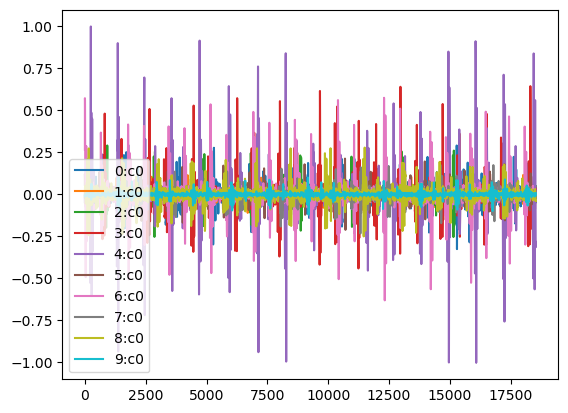

In [448]:
for i in range(10):
    plt.plot(train_x[i].flatten(),label=f'{i}:c{train_y[i]}')
plt.legend()

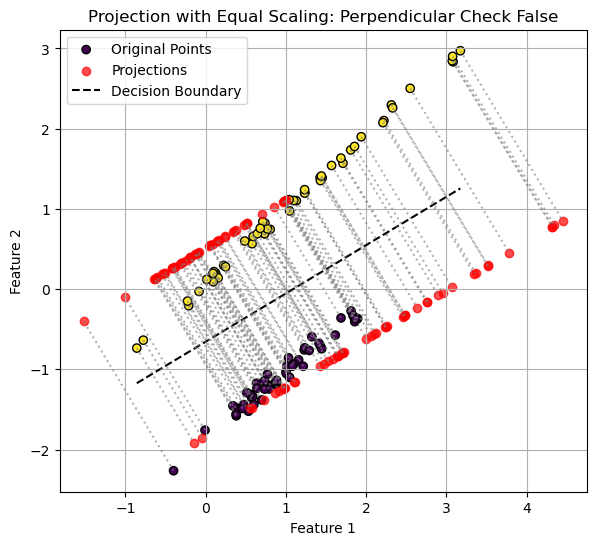

In [353]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Generate synthetic data with features on a similar scale
X, y = make_classification(
    n_samples=100, 
    n_features=2, 
    n_classes=2, 
    n_redundant=0, 
    n_clusters_per_class=1, 
    random_state=42, 
    scale=1.0
)

# Train logistic regression model
clf = LogisticRegression()
clf.fit(X, y)

# Coefficients and intercept of the logistic regression model
w = clf.coef_[0]  # Coefficients (weights)
b = clf.intercept_[0]  # Intercept (bias)

# Function to project points onto the hyperplane
def project_onto_hyperplane(points, w, b):
    w_norm = np.linalg.norm(w)
    projections = points - ((np.dot(points, w) + b) / (w_norm**2))[:, np.newaxis] * w
    return projections

def flipped_projection(points, w, b, epsilon=0.1):
    """
    Project points onto the hyperplane and then flip their positions to the opposite side.
    """
    # Regular projection
    w_norm = np.linalg.norm(w)
    projections = points - ((np.dot(points, w) + b) / (w_norm**2))[:, np.newaxis] * w

    # Determine side of the hyperplane for each point
    signed_distance = np.dot(points, w) + b
    flip_direction = -np.sign(signed_distance)  # Flip the side

    # Modify projection to the opposite side
    flipped_projections = projections + flip_direction[:, np.newaxis] * epsilon * (w / w_norm)
    return flipped_projections

# Function to verify perpendicularity
def check_projection_perpendicularity(points, projections, w):
    """
    Check that the projection lines are perpendicular to the hyperplane.
    This function calculates the dot product of the projection direction and w.
    """
    projection_vectors = points - projections
    dot_products = np.dot(projection_vectors, w)
    return np.allclose(dot_products, 0, atol=1e-6)

# Recalculate projections and debug
projections = flipped_projection(X, w, b, epsilon=1)
perpendicular_check = check_projection_perpendicularity(X, projections, w)

# Plotting the corrected projection visualization
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', edgecolor='k', label='Original Points')
plt.scatter(projections[:, 0], projections[:, 1], color='red', label='Projections', alpha=0.7)

# Plot decision boundary
x_vals = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
y_vals = -(w[0] * x_vals + b) / w[1]
plt.plot(x_vals, y_vals, 'k--', label='Decision Boundary')

# Draw lines from original points to projections (should be perpendicular)
for i in range(len(X)):
    plt.plot([X[i, 0], projections[i, 0]], [X[i, 1], projections[i, 1]], 'gray', linestyle='dotted', alpha=0.6)

# Ensure both axes use the same scaling
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f'Projection with Equal Scaling: Perpendicular Check {perpendicular_check}')
plt.legend()
plt.grid(True)
plt.show()

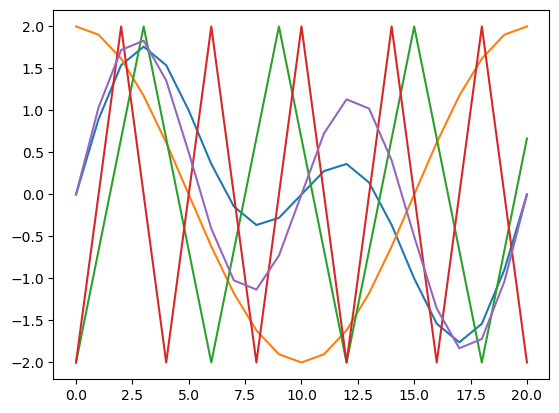

In [198]:
def create_zigzag_with_len_cycle(seq_len, cycle_len):
    """
    Generate a zigzag pattern for a sequence.

    Parameters:
        seq_len (int): Total sequence length.
        cycle_len (int): Length of one zigzag cycle (up and down).

    Returns:
        np.ndarray: An array containing the zigzag pattern.
    """
    # Ensure cycle_len is at least 2 to create a zigzag pattern
    if cycle_len < 2:
        raise ValueError("cycle_len must be at least 2.")

    # Generate one cycle of the zigzag (up and down)
    half_cycle = cycle_len // 2
    upward = np.arange(half_cycle) / half_cycle  # e.g., [0, 1, 2, ...]
    downward = np.arange(half_cycle, 0, -1) / half_cycle  # e.g., [2, 1]
    full_cycle = np.concatenate((upward, downward[:cycle_len - len(upward)]))

    # Tile the cycles to cover the full sequence length
    num_repeats = (seq_len + len(full_cycle) - 1) // len(full_cycle)
    zigzag = np.tile(full_cycle, num_repeats)[:seq_len]

    return zigzag
    
s1 = np.sin(np.linspace(0, 2 * np.pi, 21)) + np.sin(np.linspace(0, 4 * np.pi, 21))
s2 = np.cos(np.linspace(0, 2 * np.pi, 21))*2
s3 = create_zigzag_with_len_cycle(21, 7) * 4 - 2
s4 = create_zigzag_with_len_cycle(21, 5) * 4 - 2
s5 = 0.5*np.sin(np.linspace(0, 2 * np.pi, 21)) + 1.5*np.sin(np.linspace(0, 4 * np.pi, 21))
plt.plot(s1)
plt.plot(s2)
plt.plot(s3)
plt.plot(s4)
plt.plot(s5)

In [64]:
# i = 0
# diverse_training = selected_training
# diverse_probing = selected_uni
# device = 'cuda'
# xai_name = 'DeepLift'  # IntegratedGradients
# model_type = 'FCN'
# train_model = True
# example_name = f"simu9_diverse_{i}"

# lamb = 0.1
# thresh_factor = 1.5

# s7 = np.sin(np.linspace(0, 2 * np.pi, 21)) + np.sin(np.linspace(0, 4 * np.pi, 21))
# s8 = np.cos(np.linspace(0, 2 * np.pi, 21)) + np.cos(np.linspace(0, 4 * np.pi, 21))
# s9 = create_1d_zigzag_array(21)  * 4 - 2

# shapelet = s7
# instance_length = 150
# model_dataset_path = f'models/simu9_{i}'

# if train_model:
#     pdata_dict = get_pdata(shapelet=shapelet, selected_datasets=diverse_training, inst_length=instance_length,
#                            num_shapelet=1, is_add=False, repeat_max=100,
#                            is_z_norm=True,
#                            is_blending=False, blend_length=5,
#                            is_best_insert=True,
#                            save_dir=None)
#     print(pdata_dict['pdata_ws'].shape)
#     data_train = np.concatenate((pdata_dict['pdata_ws'], pdata_dict['pdata_wos']), axis=0)
#     data_label = np.array([0] * len(pdata_dict['pdata_ws']) + [1] * len(pdata_dict['pdata_wos']))

#     train_x, test_x, train_y, test_y = train_test_split(
#         data_train, data_label, test_size=0.2, random_state=42)

#     enc1 = OneHotEncoder(sparse_output=False).fit(train_y.reshape(-1, 1))
#     train_y = enc1.transform(train_y.reshape(-1, 1))
#     test_y = enc1.transform(test_y.reshape(-1, 1))
#     data = {
#         'train_x': train_x,
#         'test_x': test_x,
#         'train_y': train_y,
#         'test_y': test_y
#     }
#     if not os.path.exists(model_dataset_path):
#         os.makedirs(model_dataset_path)

#     with open(model_dataset_path + '/data.pkl', 'wb') as f:
#         pickle.dump(data, f)

#     num_class = 2
#     if model_type == 'RNN':
#         model = RNN(c_in=1, c_out=num_class)
#         un_trained_model = RNN(c_in=1, c_out=num_class)
#     elif model_type == 'FCN':
#         model = FCN(c_in=1, c_out=num_class)
#         un_trained_model = FCN(c_in=1, c_out=num_class)
#     elif model_type == 'MLP':
#         model = MLP(c_in=1, c_out=num_class, seq_len=train_x.shape[-1])
#         un_trained_model = MLP(c_in=1, c_out=num_class, seq_len=train_x.shape[-1])
#     else:
#         raise ValueError('Wrong model pick')
#     train_loader, test_loader = generate_loader(train_x, test_x, train_y, test_y, batch_size_train=128,
#                                                 batch_size_test=32)
#     fit(model, train_loader, device=device, num_epochs=200)
#     torch.save(model.state_dict(), f'{model_dataset_path}/weight.pt')
#     test_preds, ground_truth = get_all_preds(model, test_loader, device=device)
#     ground_truth = np.argmax(ground_truth, axis=1)
#     np.save(f'{model_dataset_path}/test_preds.npy', np.array(test_preds))
#     acc = accuracy_score(ground_truth, test_preds)
#     print(f'acc:{acc:.3f}')
#     a = classification_report(ground_truth, test_preds, output_dict=True)
#     dataframe = pd.DataFrame.from_dict(a)
#     dataframe.to_csv(f'{model_dataset_path}/classification_report.csv', index=False)

# else:
#     with open(model_dataset_path + '/data.pkl', 'rb') as f:
#         data = pickle.load(f)
#     data.keys()
#     train_x, test_x, train_y, test_y = data['train_x'], data['test_x'], data['train_y'], data['test_y']
#     test_preds = np.load(model_dataset_path + '/test_preds.npy')
#     test_y = np.argmax(test_y, axis=1)
#     train_y = np.argmax(train_y, axis=1)
#     num_class = 2
#     if model_type == 'RNN':
#         model = RNN(c_in=1, c_out=num_class)
#         un_trained_model = RNN(c_in=1, c_out=num_class)
#     elif model_type == 'FCN':
#         model = FCN(c_in=1, c_out=num_class)
#         un_trained_model = FCN(c_in=1, c_out=num_class)
#     elif model_type == 'MLP':
#         model = MLP(c_in=1, c_out=num_class, seq_len=train_x.shape[-1])
#         un_trained_model = MLP(c_in=1, c_out=num_class, seq_len=train_x.shape[-1])
#     else:
#         raise ValueError('Wrong model pick')
#     state_dict = torch.load(f'{model_dataset_path}/weight.pt', map_location='cuda:1')
#     model.load_state_dict(state_dict)

# un_trained_model.eval()
# model.eval()

# attr_dir = f'attributions/simu9_{i}'
# target_class = None
# # Xai
# print(xai_name)
# attr_gp, _ = get_attr(model, test_x, None, None,
#                       save_dir=os.path.join(attr_dir, f'/{xai_name}/exp.pkl'),
#                       xai_name=xai_name, target_class=target_class)

# plot_indices = np.arange(8)
# plot_multiple_images_with_attribution(test_x[plot_indices], test_y[plot_indices], 8, figsize=(12, 6),
#                                       use_attribution=True,
#                                       attributions=attr_gp[plot_indices],
#                                       normalize_attribution=True,
#                                       save_path=None,
#                                       test_y=test_preds[plot_indices],
#                                       startings=[[30]] * 8,
#                                       shapelet_length=15
#                                       )

# # feature probe:
# seen_feature = s7
# instance_length = 150
# save_dir = f'probe/simu9/feature_{i}'
# save_dir_pdata = f'probe/simu9/feature_{i}/pdata.pkl'
# pdata_dict = get_pdata(shapelet=seen_feature, selected_datasets=diverse_probing, inst_length=instance_length,
#                        num_shapelet=1, is_add=False, repeat_max=100,
#                        is_best_insert=True,
#                        is_z_norm=True, save_dir=save_dir_pdata)

# pdata_dict = pickle_load_from_file(save_dir_pdata)
# pdata = np.concatenate((pdata_dict['pdata_ws'], pdata_dict['pdata_wos']), axis=0)
# print(train_x.shape, pdata.shape)
# p_data_labels = np.array([0] * len(pdata_dict['pdata_ws']) + [1] * len(pdata_dict['pdata_wos']))

# shapelet_labels = [test_y, p_data_labels]

# # pc
# prober = ShapeletProber(model, device='cuda', save_path=save_dir, is_verbose=False)
# results = prober.probe(dataset=test_x, labels=test_y, pdata=pdata, shapelet=None, pos=None,
#                        shapelet_labels=shapelet_labels,
#                        is_threshold_info_gain=False,
#                        classifier_type='LR', save_results=True, use_saved_latent=False, merge_latent=False)

# probe_coef = results['classifier'].coef_.flatten()
# train_acc = results['train_acc']
# test_acc = results['test_acc']
# original_acc = results['accuracy']
# fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
# scores = fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight)
# print(f'probing training acc: {train_acc:.2f}')
# print(f'probing testing acc: {test_acc:.2f}')
# print(f'original instance acc: {original_acc:.2f}')
# print(scores)

# # feature on untrained
# seen_feature = s7
# instance_length = 150

# save_dir = 'probe/simu9/feature_untrained/'
# save_dir_pdata = 'probe/simu9/feature_untrained/pdata.pkl'

# pdata_dict = get_pdata(shapelet=seen_feature, selected_datasets=diverse_probing, inst_length=instance_length,
#                        # selected_datasets=diverse_probing
#                        num_shapelet=1, is_add=False, repeat_max=100,
#                        is_best_insert=True,
#                        is_z_norm=True, save_dir=save_dir_pdata)

# pdata_dict = pickle_load_from_file(save_dir_pdata)
# pdata = np.concatenate((pdata_dict['pdata_ws'], pdata_dict['pdata_wos']), axis=0)
# print(train_x.shape, pdata.shape)
# dataset_s_label = train_y
# p_data_labels = np.array([0] * len(pdata_dict['pdata_ws']) + [1] * len(pdata_dict['pdata_wos']))

# shapelet_labels = [train_y, p_data_labels]

# # pc
# results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=un_trained_model, save_path=save_dir,
#                          shapelet=seen_feature, pos=None, device='cuda:1', shapelet_labels=shapelet_labels)

# probe_coef = results['classifier'].coef_.flatten()
# train_acc = results['train_acc']
# test_acc = results['test_acc']
# original_acc = results['accuracy']
# fc_weight_untrained = un_trained_model.fc.weight[0].clone().cpu().detach().numpy()
# scores = fc_weight_untrained @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight)
# print(f'probing training acc: {train_acc:.2f}')
# print(f'probing testing acc: {test_acc:.2f}')
# print(f'original instance acc: {original_acc:.2f}')
# print(scores)

# # non-feature probe:
# seen_nonfeature = test_x[4, :, 30:45].flatten()
# instance_length = 150

# save_dir = 'probe/simu9/nonfeature'
# save_dir_pdata = 'probe/simu9/nonfeature/pdata.pkl'
# pdata_dict = get_pdata(shapelet=seen_nonfeature, selected_datasets=diverse_probing, inst_length=instance_length,
#                        # selected_datasets=diverse_probing
#                        num_shapelet=1, is_add=False, repeat_max=100,
#                        is_best_insert=True,
#                        is_z_norm=True, save_dir=save_dir_pdata)

# pdata_dict = pickle_load_from_file(save_dir_pdata)
# pdata = np.concatenate((pdata_dict['pdata_ws'], pdata_dict['pdata_wos']), axis=0)
# print(train_x.shape, pdata.shape)
# p_data_labels = np.array([0] * len(pdata_dict['pdata_ws']) + [1] * len(pdata_dict['pdata_wos']))

# shapelet_labels = [test_y, p_data_labels]

# # pc
# prober = ShapeletProber(model, device='cuda', save_path=save_dir, is_verbose=False)
# results = prober.probe(dataset=test_x, labels=test_y, pdata=pdata, shapelet=None, pos=None,
#                        shapelet_labels=shapelet_labels,
#                        is_threshold_info_gain=False,
#                        classifier_type='LR', save_results=True, use_saved_latent=False, merge_latent=False)

# # results = probe_shapelet(dataset=train_x, labels=train_y, pdata=pdata, model=model, save_path=save_dir,
# #                          shapelet=seen_feature, pos=None, device='cuda:1',shapelet_labels=shapelet_labels)

# probe_coef = results['classifier'].coef_.flatten()
# train_acc = results['train_acc']
# test_acc = results['test_acc']
# original_acc = results['accuracy']
# fc_weight = model.fc.weight[0].clone().cpu().detach().numpy()
# scores = fc_weight @ probe_coef / np.linalg.norm(probe_coef) / np.linalg.norm(fc_weight)
# print(f'probing training acc: {train_acc:.2f}')
# print(f'probing testing acc: {test_acc:.2f}')
# print(f'original instance acc: {original_acc:.2f}')
# print(scores)

array([ 3.23216767, -0.84594518])

In [180]:
arr = np.array([1, 2, 3, 4, 5])

# Length of the subsequence
k = 3

# Define a function to compute the sum of a subsequence of length k
def subsequence_sum(start_idx):
    return np.sum(arr[start_idx:start_idx+k])

# Create a vectorized version of the subsequence_sum function
vectorized_subsequence_sum = np.vectorize(subsequence_sum)

# Generate all valid start indices for subsequences of length k
valid_indices = np.arange(len(arr) - k + 1)

# Apply the vectorized function to compute the sum for each subsequence
subsequence_sums = vectorized_subsequence_sum(valid_indices)

print(subsequence_sums)

[ 6  9 12]


In [195]:
def get_seen_nonfeature(inst, attr, k):
    neg_abs_attr = -np.abs(attr)  # Ensure attr is 2D, so no need for flattening

    # Define a function to compute the sum of a subsequence of length k for a given row
    def subsequence_sum(row, start_idx):
        
        print(start_idx,k,row)
        return np.sum(row[start_idx:start_idx + k])

    # Create a vectorized version of the subsequence_sum function
    vectorized_subsequence_sum = np.vectorize(subsequence_sum)

    # Initialize variables to track the overall minimum subsequence
    min_sum = float('inf')
    min_row_idx = -1
    min_start_idx = -1

    # Iterate through each row in neg_abs_attr
    for row_idx in range(neg_abs_attr.shape[0]):
        row = neg_abs_attr[row_idx]
        print(row)
        # Generate all valid start indices for subsequences of length k
        valid_indices = np.arange(len(row) - k + 1)
        print(valid_indices)
        # Apply the vectorized function to compute the sum for each subsequence
        subsequence_sums = vectorized_subsequence_sum(row, valid_indices)
        
        # Find the minimum subsequence sum for this row
        row_min_idx = np.argmax(subsequence_sums)
        row_min_sum = subsequence_sums[row_min_idx]
        
        # Update the overall minimum subsequence if needed
        if row_min_sum < min_sum:
            min_sum = row_min_sum
            min_row_idx = row_idx
            min_start_idx = valid_indices[row_min_idx]

    # Return the subsequences with the smallest sum from both inst and attr
    return inst[min_row_idx, min_start_idx:min_start_idx + k], attr[min_row_idx, min_start_idx:min_start_idx + k]

inst = np.array([[1, 2, 3, 4, 5],
                 [5, 4, 3, 2, 1],
                 [6, 7, 8, 9, 10]])

attr = np.array([[10, 9, 8, 7, 6],
                 [5, 4, 3, 2, 1],
                 [1, 2, 3, 4, 5]])

k = 3


result_inst, result_attr = get_seen_nonfeature(inst, attr, k)

print("Result from inst:", result_inst)
print("Result from attr:", result_attr)

[-10  -9  -8  -7  -6]
[0 1 2]
0 3 -10


IndexError: invalid index to scalar variable.

In [21]:
import re
def remove_trailing_digits(value):
    return re.sub(r'\d+$', '', value)
    
prefix = 'implet_cluster'

In [17]:
df = pd.read_csv(f'experiments/GunPoint/df.csv')


,Unnamed: 0,dataset,probe_choice,train_acc,test_acc,original_acc,tcav_score,cf_score
0,0,GunPointc_0,nonfeature,0.516369,0.452381,0.520000,0.015061,0.0
1,1,GunPointc_0,implet_cluster0,0.518601,0.447917,0.520000,0.009960,0.0
2,2,GunPointc_0,implet_cluster1,0.546875,0.497024,0.906667,0.121876,0.0
3,3,GunPointc_0,implet_cluster2,0.590774,0.590774,0.946667,0.080228,0.0
4,4,GunPointc_0,implet_cluster3,0.542039,0.477679,0.140000,0.160199,0.0
5,5,GunPointc_0,implet_cluster_untrained0,0.526414,0.418155,0.553333,0.036290,0.0
6,6,GunPointc_0,implet_cluster_untrained1,0.542783,0.479167,0.793333,0.187916,0.0
7,7,GunPointc_0,implet_cluster_untrained2,0.575893,0.510417,0.853333,0.113866,0.0
8,8,GunPointc_0,implet_cluster_untrained3,0.553199,0.497024,0.860000,0.027319,0.0
9,9,GunPointc_0,one_implet0,0.526042,0.418155,0.453333,0.112522,0.0


In [12]:
# df = pd.read_csv(f'experiments/GunPoint/df.csv')
# df['tcav_score'] = df['tcav_score'].abs()
# df = df.drop('original_acc',axis=1)
# df = df.rename(columns={"train_acc": "probing acc (train)", "test_acc": "probing acc (test)"})
# df

,Unnamed: 0,dataset,probe_choice,probing acc (train),probing acc (test),tcav_score,cf_score
0,0,GunPoint,nonfeature,0.543899,0.468750,0.108750,0.006667
1,1,GunPoint,implet_cluster0,0.610119,0.577381,0.090981,0.000000
2,2,GunPoint,implet_cluster1,0.580357,0.549107,0.118946,0.000000
3,3,GunPoint,implet_cluster_untrained0,0.626488,0.572917,0.071679,0.000000
4,4,GunPoint,implet_cluster_untrained1,0.569196,0.495536,0.148228,0.000000
5,5,GunPointc_0,one_implet0,0.640253,0.619048,0.060099,0.000000
6,6,GunPointc_0,one_implet1,0.609003,0.587798,0.171065,0.000000
7,7,GunPointc_0,one_implet_untrained0,0.627604,0.592262,0.110050,0.000000
8,8,GunPointc_0,one_implet_untrained1,0.616071,0.638393,0.103845,0.000000
9,9,GunPoint,nonfeature,0.543899,0.477679,0.085405,0.000000


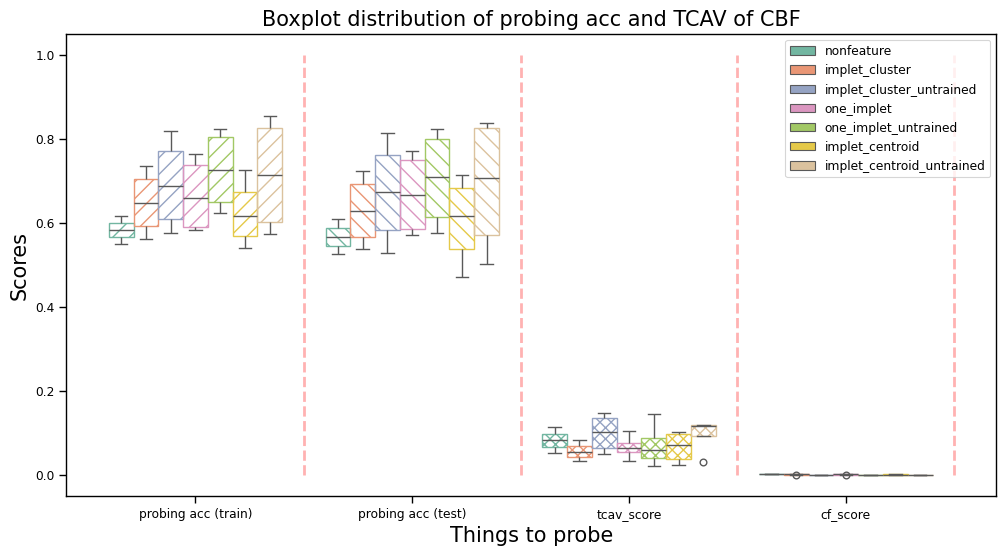

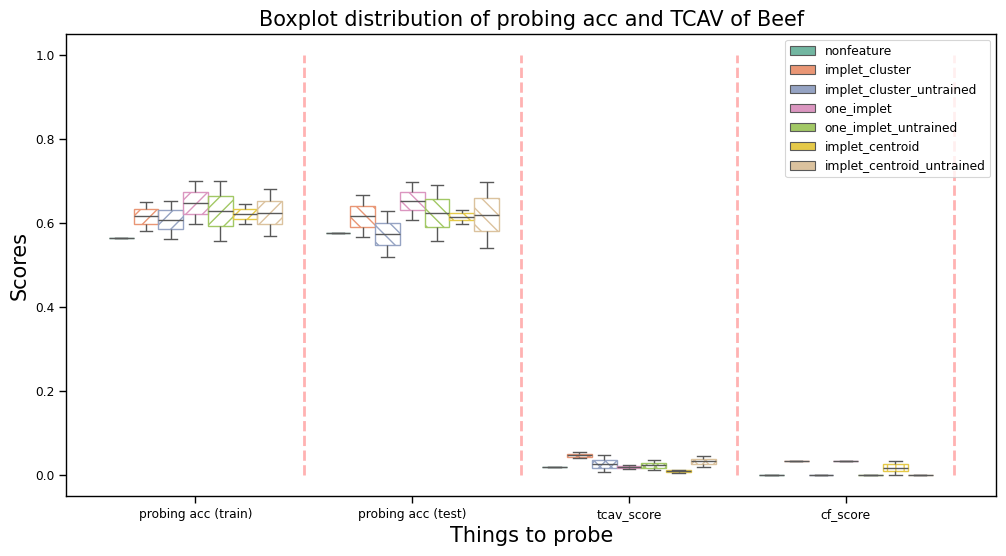

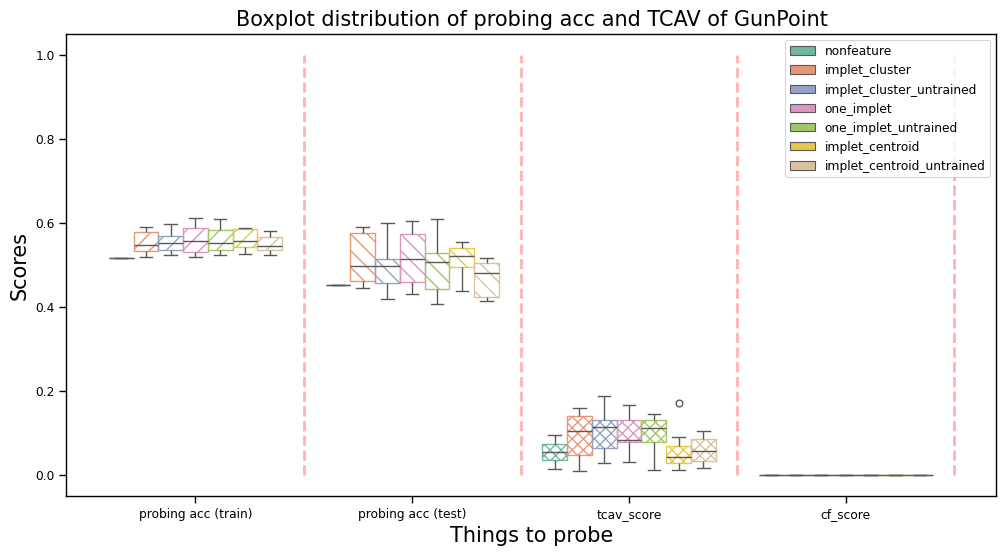

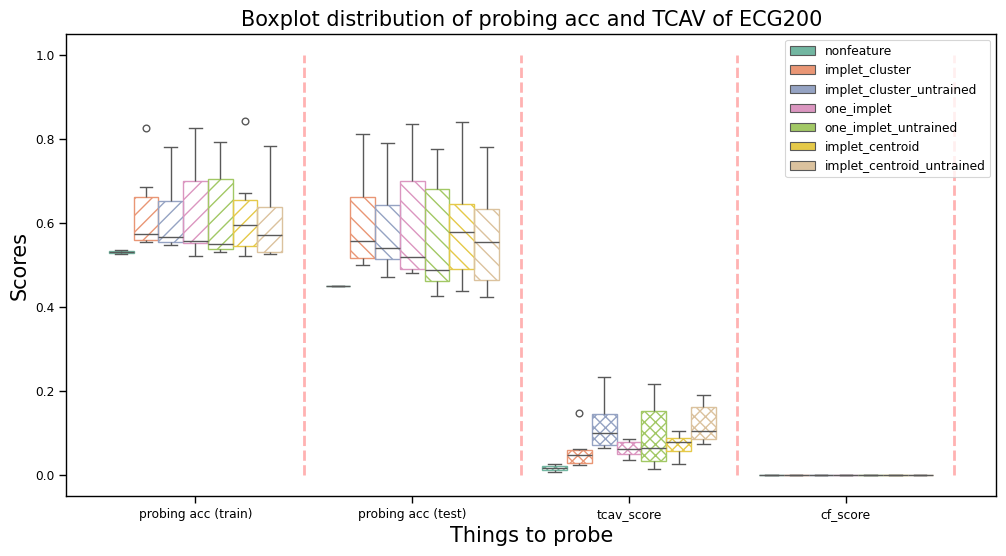

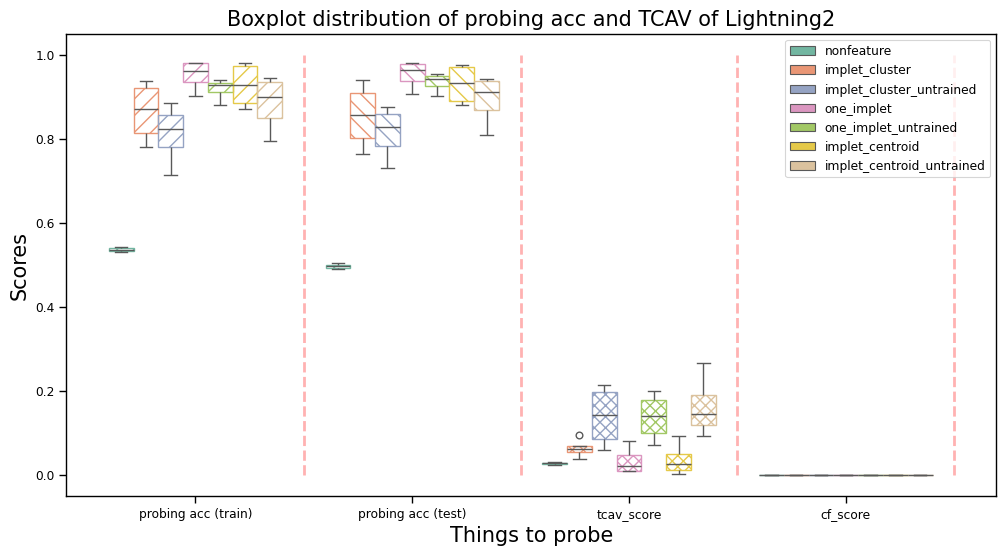

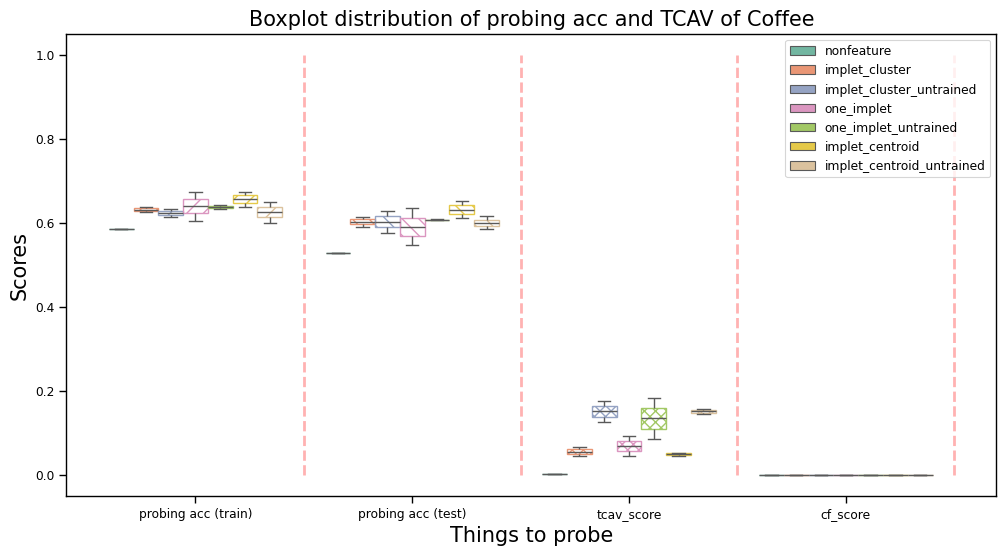

In [85]:
# df_filtered = df_melted[df_melted['variable'].isin(columns_to_plot)]
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#
datasets = ['CBF', 'Beef', 'GunPoint', 'ECG200', 'Lightning2', 'Coffee']
for dataset in datasets:
    df = pd.read_csv(f'experiments/{dataset}/df.csv')
    # don't care any implet clusters
    df['probe_choice'] = df['probe_choice'].apply(lambda x: remove_trailing_digits(x))
    df['tcav_score'] = df['tcav_score'].abs()
    df = df.drop('original_acc',axis=1)
    df = df.rename(columns={"train_acc": "probing acc (train)", "test_acc": "probing acc (test)"})
    df.to_csv(f'./experiments/_summary_k_none/df_{dataset}.csv')

    # 创建一个箱型图，按 Category 分组，并且按 Subcategory 使用 hue
    plt.figure(figsize=(12,6))
    
    _df = pd.melt(df, id_vars=['probe_choice'], value_vars=["probing acc (train)","probing acc (test)",'tcav_score','cf_score'], 
                        var_name='Subcategory', value_name='Value')
    
    # _df = _df[~((_df['probe_choice']=='feature_untrained')&(_df['Subcategory'].isin(['cf_score','tcav_score'])))]
    # sns.boxplot(x='Subcategory', y='Value', hue='probe_choice', data=_df, palette='Set2')
    
    ax = sns.boxplot(
        x='Subcategory', 
        y='Value', 
        hue='probe_choice', 
        data=_df, 
        palette='Set2'
    )
    sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
    # Add hatches to the bars
    hatches = ['//', '\\\\','xxx','||']  # Define hatches for different hue levels
    patches = [patch for patch in ax.patches if isinstance(patch, mpatches.PathPatch)]
    
    # Apply hatches manually
    for i, patch in enumerate(patches):
        
        hatch = hatches[i % len(hatches)]  # Cycle through hatches
        patch.set_hatch(hatch)
        patch.set_edgecolor(patch.get_facecolor())
        patch.set_facecolor('none')
        # for this_bar in these_bars:
            
        # if lbl.get_text() == "probing acc (train)":
        #     patch.set_hatch('//')
        #     patch.set_edgecolor(patch.get_facecolor())
        #     patch.set_facecolor('none')
        # elif lbl.get_text() == "probing acc (test)": 
        #     print(lbl.get_text())
        #     patch.set_hatch('||')
        #     patch.set_edgecolor(patch.get_facecolor())
        #     patch.set_facecolor('none')
        # elif lbl.get_text() == "tcav_score": 
        #     patch.set_hatch('xx')
        #     patch.set_edgecolor(patch.get_facecolor())
        #     patch.set_facecolor('none')            
    categories = _df['Subcategory'].unique()
    for i, category in enumerate(categories):
        plt.plot([i+0.5, i+0.5],[0, 1], color='red', lw=2,alpha=0.3,linestyle='--')
    # 添加标题和标签
    plt.title(f'Boxplot distribution of probing acc and TCAV of {dataset}')
    plt.xlabel('Things to probe')
    plt.ylabel('Scores')
    plt.legend(loc="upper right")
    # 显示图形
    # plt.show()
    plt.savefig(f'./experiments/_summary_k_none/boxplot_{dataset}.png')

In [363]:
df = df.loc[~(df['probe_choice'] == 'implet_cluster_untrained0')]

,probe_choice,Subcategory,Value
0,feature,probing acc (train),0.999277
1,nonfeature,probing acc (train),0.695087
2,feature_untrained,probing acc (train),0.867052
3,implet_cluster0,probing acc (train),0.893425
4,feature,probing acc (train),0.999639
...,...,...,...
73,nonfeature,cf_score,0.000000
75,implet_cluster0,cf_score,0.003724
76,feature,cf_score,1.000000
77,nonfeature,cf_score,0.000000


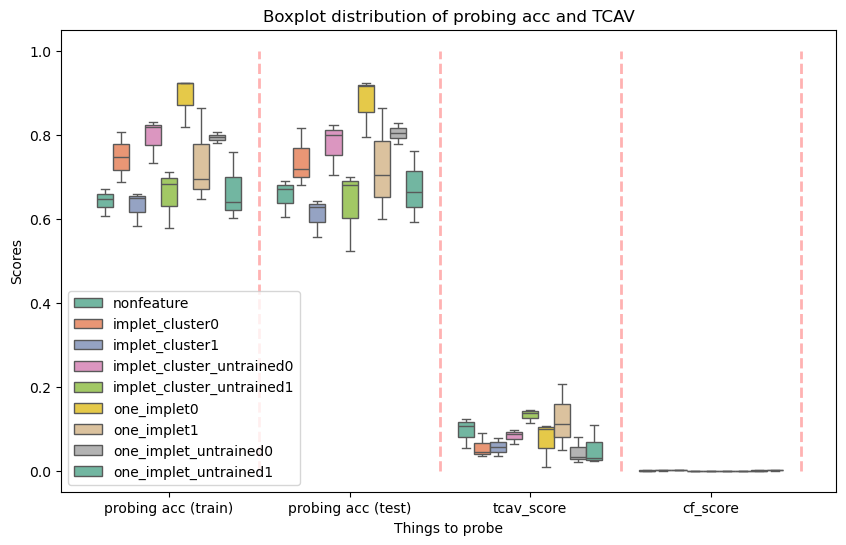

In [30]:
cluster_results = pickle_load_from_file('experiments/GunPoint/probe/class_None_sample_pred_0/IntegratedGradients/implets_cluster_results.pkl')

In [33]:
len(cluster_results['best_centroids_dep'])

4

In [38]:
for i in range(4):
    print(cluster_results['best_centroids_dep'][i][:,0].shape)

(5,)
(5,)
(11,)
(8,)
